# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
#Импорт библиотек
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.resnet import ResNet50 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

* Для загрузки данных используем загрузчик из библиотеки Keras - ImageDataGenerator. 
* Сначала посмотрим на исходные данные, для этого загрузим фотографии

Found 7591 validated image filenames.
Фотографии из датасета с возрастом чекловека на каждой фотографии


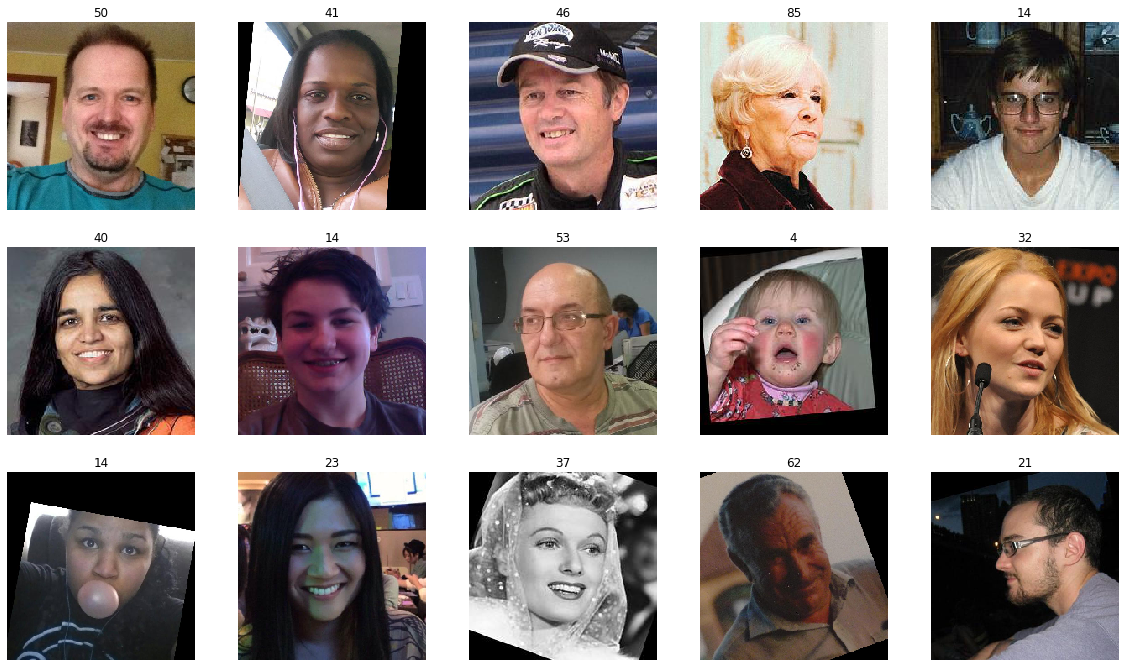

In [7]:
#Загрузка фотографий
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
features, target = next(train_gen_flow)
#Показ фотографий в датасете
print('Фотографии из датасета с возрастом чекловека на каждой фотографии')
plt.figure(figsize=(20,20)) 
for i in range(15):
    plt.subplot(5,5,i+1)    
    plt.imshow(features[i])
    plt.title(target[i])
    plt.axis('off')
plt.show()

Посмотрим на распределение фотографий по возрасту

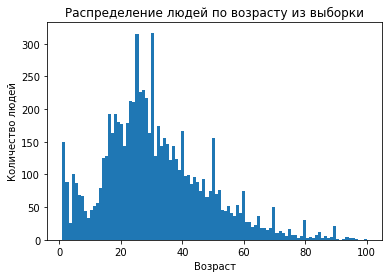

In [46]:
#Распределение людей по возраст
plt.hist(bins = 100, x = labels['real_age'])
plt.ylabel('Количество людей')
plt.xlabel('Возраст')
plt.title('Распределение людей по возрасту из выборки')
plt.show()

### Выводы по данным
* Обучающая выборка составляет 5700 фотографий, этого вроде достаточно, но так как диапазон возраста составляет от 0 до 100 лет, то на каждый год приходится в среднем 6 фотографий (если не учитывать смещение, что достаточно мало). 
* Но так как есть смещение в сторону возраста до 40 лет, то модель будет лучше определять возраст до 40, чем после 40 (из-за недостатка данных по каждому году)  
* На гистрограмме наблюдаем пики каждые 10 лет. Это может быть связано с тем, что в юбилейные года люди больше выкладывают фотграфий, но в подборке фотографий очень мало фотографий с дня рождения. Гипотеза в том, что в одном из источников, в котором собирались данные - данные округлялись до ближайщих десяти лет. 
* Часть исходных фото уже повернуты, убран фон. То есть это датасеты из уже подготовленных данных.

## Обучение модели

Для обучения модели использовались сервера Яндекс.Практикума, поэтому написал функции для згрузки данных, создания и обучения модели 

* При загрузке данны использовалась аугментация (горизонтальное отражение) для повышение качества модели, также из предыдущеого пункта видели, что часть данных уже повернутв на случайный угол, что в свою очередь повышает качество модели (создает реальные условия фотографирования людей около кассы магазина)
* Создадим модель с помощью модификации ResNet50 с добавлением полносвязного слоя с 1 нейроном, так как решаем задачу регрессии. 
* Для функции активации использем Relu, так как это самая оптимальна функция для баланса качества/скорости работы.
* Минимизируем метрику MAE, так как она легко интерпретируемая: MAE равная 1 значит, что в среднем модель будет ошибаться на 1 год. Поставим target значение MAE равное 7 (в среднем модель ошибается на 7 лет) 
* Обучим модель на 15 эпохах, чтобы достичь требуемого значения MAE

```python

def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(
        horizontal_flip = True
        rescale=1/255.,
        validation_split=0.25)       
    train_datagen_flow = datagen.flow_from_dataframe(dataframe = labels,
                                                     directory = f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25)    
    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels, directory = f'{path}final_files/', 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return val_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    model.summary()
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Ниже приведен код по результатам обучения

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
  ...
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 131s - loss: 231.7557 - mae: 10.9035 - val_loss: 699.2904 - val_mae: 21.4429
Epoch 2/10
178/178 - 42s - loss: 76.2563 - mae: 6.5353 - val_loss: 710.1543 - val_mae: 21.4901
Epoch 3/10
178/178 - 42s - loss: 48.8502 - mae: 5.2836 - val_loss: 288.9361 - val_mae: 12.3765
Epoch 4/10
178/178 - 42s - loss: 36.0505 - mae: 4.5972 - val_loss: 117.0832 - val_mae: 8.0744
Epoch 5/10
178/178 - 42s - loss: 27.2597 - mae: 3.9648 - val_loss: 76.9817 - val_mae: 6.6990
Epoch 6/10
178/178 - 42s - loss: 21.4749 - mae: 3.5610 - val_loss: 68.4958 - val_mae: 6.2226
Epoch 7/10
178/178 - 42s - loss: 16.6913 - mae: 3.1432 - val_loss: 63.2562 - val_mae: 5.8746
Epoch 8/10
178/178 - 42s - loss: 14.7758 - mae: 2.8790 - val_loss: 69.4177 - val_mae: 6.1352
Epoch 9/10
178/178 - 42s - loss: 11.5831 - mae: 2.6150 - val_loss: 62.5607 - val_mae: 5.9684
Epoch 10/10
178/178 - 42s - loss: 11.0706 - mae: 2.5277 - val_loss: 64.7103 - val_mae: 6.0519
Found 5694 validated image filenames.
60/60 - 10s - loss: 64.7103 - mae: 6.0519
Test MAE: 6.0519

```

## Анализ обученной модели

* Модель ResNet50, настоенная на задачу регресси дает MAE 6,1 на тестовой выборке. Изменения в модели относительно изначальной - полносвяный слой содержит 1 нейрон для выдачи значения как результат обучения модели. 
* Показатель MAE равный 6,1 означает, что модель в среднем ошибается на 6,1 лет при определении возраста, достаточно много для большей части выборки, но достаточно для начала настройки модели (ошибка в 15% для основной части выборки - людей меньше 40 лет)